<style>
#s {
}
h1, h2, h3, h4, h5, h6, table, button, a, p, blockquote {
font-family:Geneva;
}

.log {
transition: all .2s ease-in-out;
}

.log:hover {a
transform: scale(1.05);
}
</style>
<div id='s' style='width:90%'>
<center><img class='log' src='https://splicemachine.com/wp-content/uploads/splice-logo-1.png' width='20%' style='z-index:5'></center>
<center><h1 class='log' style='font-size:40px; color:black;'>Welcome to Splice Machine MLManager</h1></center>
<center><h2 class = 'log' style='font-size:25px; color:grey;'>The data platform for intelligent applications</center>
<center><img class='log' src='https://splice-demo.s3.amazonaws.com/splice-machine-data-science-process-h2o.png' width='40%' style='z-index:5'></center>
</div>
    
    

# In this notebook, we're going to take a look at using MLManager with [H2O](https://www.h2o.ai/) + [Spark](https://spark.apache.org/)
<h2 style='font-size:25px;  font-weight:bold'>What is <a href=http://docs.h2o.ai/sparkling-water/2.1/latest-stable/doc/pysparkling.html>PySparkling Water?</a> What is <a href=https://splicemachine.com/product/ml-manager/>MLManager?</a></h2>
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>PySparkling</span></b> <br><br>PySparkling Water is an awesome H2O extension that allows you to run H2O clusters on top of existing Spark clusters. With Splice Machine, this integration is taken care of for you, so it's simple to start modeling with your new favorite library</i></br><footer>Splice Machine</footer></blockquote><br>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>MLManager (+MLFlow)</span></b><br><br>As a data scientist constantly creating new models and testing new features, it is necessary to effectively track and manage those different ML runs. MLManager + MLFlow allows you to track entire <code>experiments</code> and individual <code>run</code> parameters and metrics. The way you organize your flow is unique to you, and the intuitive Python API allows you to organize your development process and run with it.<br>
     <center><img class='log' src='https://s3.amazonaws.com/splice-demo/mlflow+ui.png' width='40%' style='z-index:5'></center>

# Let's get started
## In this notebook, we will see how to use Spark, H2O and MLManager to predict sentiment analysis of Amazon reviews, tracking everything in the [MLFlow UI](/mlflow) and deploy our models to production
This is an adaptation of the original [H2O Demo](http://docs.h2o.ai/h2o-tutorials/latest-stable/h2o-world-2017/nlp/index.html)

## Important imports and setup
* Create our Spark Session
* Create our Native Spark Data Source
* Create our PySparkling Water cluster
* Import our MLManager functionality

In [2]:
pip install --upgrade git+https://www.github.com/splicemachine/pysplice@DBAAS-3990

  Cloning https://www.github.com/splicemachine/pysplice (to revision DBAAS-3990) to /tmp/pip-req-build-p0zbcnu1
  Running command git clone -q https://www.github.com/splicemachine/pysplice /tmp/pip-req-build-p0zbcnu1
  Running command git checkout -b DBAAS-3990 --track origin/DBAAS-3990
  Switched to a new branch 'DBAAS-3990'
  Branch 'DBAAS-3990' set up to track remote branch 'DBAAS-3990' from 'origin'.
  Created wheel for splicemachine: filename=splicemachine-2.0.0-py3-none-any.whl size=54523 sha256=a8d02a84f8732678b24b45d55550879c15e0d895ea98b5ad3bd7ebf7bff88551
  Stored in directory: /tmp/pip-ephem-wheel-cache-ivntjyu6/wheels/0c/58/ec/d4dd5d3e14310dcd82c132198196b6973a4139393dee4ddd79
Successfully built splicemachine
  Attempting uninstall: splicemachine
    Found existing installation: splicemachine 2.0.0
    Uninstalling splicemachine-2.0.0:
      Successfully uninstalled splicemachine-2.0.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
from splicemachine.mlflow_support import *
from pysparkling import *
import h2o

# Spark Session
spark = SparkSession.builder.config('spark.driver.memoryOverhead',1000).config('spark.driver.memory','2g').getOrCreate()
#spark.scheduler.minRegisteredResourcesRatio=1
# Native Spark Data Source
splice = PySpliceContext(spark)
# Register Splice so we can access database functions
mlflow.register_splice_context(splice)
# Create H2O Cluster
conf = H2OConf().setInternalClusterMode()
hc = H2OContext.getOrCreate(conf)

Connecting to H2O server at http://10.128.25.130:54321 ... successful.


H2O cluster uptime:,12 secs
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,2 months and 16 days
H2O cluster name:,sparkling-water-jovyan_spark-application-1591147790767
H2O cluster total nodes:,2
H2O cluster free memory:,7.667 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,10
H2O cluster status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.28.1.2-1-2.4
 * H2O name: sparkling-water-jovyan_spark-application-1591147790767
 * cluster size: 2
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (1,10.128.24.155,54321)
  (2,10.128.30.180,54321)
  ------------------------

  Open H2O Flow in browser: http://10.128.25.130:54321 (CMD + click in Mac OSX)

    


# Great! Now let's import our data
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>Importing Data</span></b> <br><br>There are a few easy ways to get data into Splice Machine, and we'll demonstrate 2 of them here. You can use the built-in <code>%%sql</code> magic to import data directly from external sources, such as S3, or you can use H2O to directly read the data from S3, create a table from that dataframe, and insert the data directly using the <code>PySpliceContext</code> you created in the cell above. </i></br><footer>Splice Machine</footer></blockquote><br>

## Option 1: Direct Import from SQL
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>SQL Import</span></b> <br><br>This method is simple: Create your table, point it to a an S3 location, and run the import command</i></br><footer>Splice Machine</footer></blockquote><br>

In [4]:
%%sql
DROP TABLE IF EXISTS AMAZON_REVIEWS;
CREATE TABLE AMAZON_REVIEWS(
    PRODUCTID VARCHAR(250),
    USERID VARCHAR(250),
    SUMMARY VARCHAR(500),
    SCORE INT,
    HELPFULNESSDENOMINATOR BIGINT,
    ID INT,
    PROFILENAME VARCHAR(500),
    HELPFULNESSNUMERATOR BIGINT,
    REVIEW_TIME BIGINT,
    REVIEW VARCHAR(15000)
);


-- Import the data
call SYSCS_UTIL.IMPORT_DATA (
     null,
     'AMAZON_REVIEWS',
     null,
     's3a://splice-demo/AmazonReviews.csv',
     ',',
     null,
     null,
     null,
     null,
     -1,
     's3a://splice-demo/bad',
     null, 
     null);

Sql started successfully



In [2]:
%%sql
select top 10 * from AMAZON_REVIEWS

Sql started successfully



In [7]:
# Get data from table into Spark Dataframe
df2 = splice.df('select * from REPLACE_ME_DBSCHEMA.amazon_reviews')
hdf = hc.asH2OFrame(df2)
hdf.describe()

Rows:99999
Cols:10




,PRODUCTID,USERID,SUMMARY,SCORE,HELPFULNESSDENOMINATOR,ID,PROFILENAME,HELPFULNESSNUMERATOR,REVIEW_TIME,REVIEW
type,string,string,string,int,int,int,string,int,int,string
mins,NaN,NaN,NaN,1.0,0.0,3.0,NaN,0.0,940809600.0,NaN
mean,NaN,NaN,NaN,4.186101861018622,2.236472364723646,284618.2923129272,NaN,1.745467454674538,1296171870.3266754,NaN
maxs,NaN,NaN,NaN,5.0,878.0,568436.0,NaN,866.0,1351209600.0,NaN
sigma,NaN,NaN,NaN,1.309542187819562,8.805400733729012,164159.3591659332,NaN,8.171450255812875,48107386.40835959,NaN
zeros,0,0,0,0,47593,0,0,53553,0,0
missing,0,0,0,0,0,0,0,0,0,0
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1.0,2.0,41471.0,Evan Eberhardt,2.0,1348358400.0,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
1,B001EO69SS,A19Q6EHPUDOMBE,Nuitrition not included.,1.0,2.0,335387.0,Voltaire,2.0,1321747200.0,"I purchased this thinking ""the Italians are good with food, this should be delicious."" If you know anything about food, it looses its nutrition the more it's cooked. This product comes pre-cooked, par-boiled. Black rice is a rich, nutty, food that is so filling it's like a whole meal. Foodies love it because it balance out the usual plate of protein, vegetables, and starch with flavorful starch. It can be eaten alone, with milk as a breakfast, with beans in the forest or as a centerpiece of exotic meal.<br />However, the reason we love this stuff is because it's high in vitamins. Not this stuff. Par-boiling then drying it out destroys much of the vitamins and flavor.<br /><br />Stay far, far away if you want vitamins and flavor."
2,B0007A0AQM,A29OX3XJ0QDI02,Doesn't like,1.0,6.0,143590.0,Mocha272,4.0,1316044800.0,My dog refuses to eat it and it smells pretty bad. I can't recommend it as treat when my dog refuses to touch it.


## Option 2: Import from H2O
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>H2O Import</span></b> <br><br>This method is also straightforward, and may be preferable to Data Scientists: Import your data using H2O, and then use the <code>PySpliceContext</code> to create the table from the dataframe and insert the data directly. You'll notice that this method doesn't directly involve any SQL.</i></br><footer>Splice Machine</footer></blockquote><br>

In [2]:
data_path = "https://splice-demo.s3.amazonaws.com/AmazonReviews.csv"
# Load data into H2O
reviews = h2o.import_file(data_path)
reviews.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)<br /><br />They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats."
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!"
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.<br /><br />The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.<br /><br />If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amo

## H2O offers great functions to convert H2OFrames into Pandas and Spark DataFrames

In [3]:
# Spark DataFrame
df = hc.asSparkFrame(reviews, copyMetadata=False)
df.limit(100).show()
del df._h2o_frame
print(type(df))
# Pandas DataFrame
pdf = reviews.head().as_data_frame()
display(pdf)
print(type(pdf))

+----------+--------------+--------------------+-----+----------------------+------+--------------------+--------------------+----------+--------------------+
| ProductId|        UserId|             Summary|Score|HelpfulnessDenominator|    Id|         ProfileName|HelpfulnessNumerator|      Time|                Text|
+----------+--------------+--------------------+-----+----------------------+------+--------------------+--------------------+----------+--------------------+
|B006BXV130|A188JOXWF4EY1R|Enjoyed by my Family|    4|                     0|223710|Ann B. Hibbard "a...|                   0|1331596800|I had no idea wha...|
|B001D0IZBW| AMBU96SBSZW3I|Best Decaf I've T...|    5|                     0|531064|         Maryann Oda|                   0|1293580800|This is by far th...|
|B004RZA6XA| AUEK6KM2T5XZ5|     Excellent stuff|    5|                     0| 91641|       W. J. Regotti|                   0|1343347200|Great in water an...|
|B002QWP8H0|A1TGNK1ISA9P3C|Saw a difference ..

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1323907200,"Everything is ok, except it just isn't as good..."
2,B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1310601600,Best cat treat ever. There isn't anything comp...
3,B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1316131200,My two Corgis were thoroughly spoiled by my la...
4,B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1334793600,We used to have drive down to the specialty pe...
5,B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1277251200,"I really liked this coffee, it was just as goo..."
6,B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1343692800,"I am always looking for healthier, whole grain..."
7,B001R3BQFW,AM50E42AFUVNL,Taste great.,5,0,126555,"T. Higley ""Tina""",0,1323561600,"I have tried many different drink mix, this is..."
8,B005HGAV8I,A2I5KDNOESGJ1H,variety galore,5,1,438837,TJ,1,1334016000,This is my favorite item to order for my Keuri...
9,B000GFYRHQ,A3A7YUR6FS6ZCI,Bigelow Earl Grey Green Tea,5,0,245379,Tea Lover,0,1178409600,"Tastes like Earl Grey, but it's green tea so i..."


<class 'pandas.core.frame.DataFrame'>


## Nice!
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>Create Table and Insert Data</span></b> <br><br>Now that we have our Spark DataFrame, we can create a table and insert data using <code>splice.createTable</code> and <code>splice.insert</code><br><b>Note: </b>If your code is hanging on the <code>insert</code> your cluser may be out of memory. Try configuring your Spark or H2O cluster with more memory. Read about that <a href=https://docs.h2o.ai/sparkling-water/2.1/latest-stable/doc/configuration/configuration_properties.html>here</a> and <a href=https://spark.apache.org/docs/latest/configuration.html#available-properties>here</a></footer></blockquote><br>


In [4]:
help(splice.createTable)
print('----------------------------------------------------------------------------------------------------------------')
help(splice.insert)

Help on method createTable in module splicemachine.spark.context:

createTable(dataframe, schema_table_name, primary_keys=None, create_table_options=None, to_upper=False, drop_table=False) method of splicemachine.spark.context.PySpliceContext instance
    Creates a schema.table from a dataframe
    :param dataframe: The Spark DataFrame to base the table off
    :param schema_table_name: str The schema.table to create
    :param primary_keys: List[str] the primary keys. Default None
    :param create_table_options: str The additional table-level SQL options default None
    :param to_upper: bool If the dataframe columns should be converted to uppercase before table creation
                        If False, the table will be created with lower case columns. Default False
    :param drop_table: bool whether to drop the table if it exists. Default False. If False and the table exists,
                       the function will throw an exception.

-------------------------------------------

In [4]:
# Create the table
schema = 'splice'
df = df.withColumnRenamed('Time', 'Review_Time')
df = df.withColumnRenamed('Text', 'Review')
splice.createTable(df, f'{schema}.AMAZON_REVIEWS_H2O', to_upper=True, drop_table=True)

Droping table splice.AMAZON_REVIEWS_H2O


## Now we can insert our dataframe

In [5]:
print('Inserting... ', end='')
splice.insert(df, f'{schema}.AMAZON_REVIEWS_H2O',to_upper=True) # Use to_upper to give the SQL table uppercase columns
print('Done.')

Inserting... Done.


In [6]:
%%sql
select top 10 varchar(Summary) Summary, Score, HelpfulnessDenominator, Id  from AMAZON_REVIEWS_H2O;

Sql started successfully



# Awesome! Let's get modeling
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>Modeling</span></b> <br><br>We're going to try three different ways to approach this problem, and track it all with MLManager. 
    <ol>
        <li>No Text Model: We will try to predict the customer reviews without using the text from the review. Just the Numeric Columns</li>
        <li>Using the reviews: We will use Word2Vec to create vectors from the text of the reviews. We will then train a model on that word embedding feature-vector</li>
        <li>Using the review summaries: We will use Word2Vec to create vectors from the text of the review summaries</li>
    </ol>
    Which do you think will perform the best?
    </i></br><footer>Splice Machine</footer></blockquote><br>

## First Attempt
Let's create a simple model using the non-review columns
<br>
<blockquote>
    First, let's start our mlflow experiment! We can start a run and log import parameters, tags, and metrics as they come<br>
Next, we can turn this into a binary-classification problem by turning score into a positive or negative review. We will say that 4 and 5 start reviews are positive, but you can change this and try other things!
</br><footer>Splice Machine</footer></blockquote><br>

In [7]:
# Set our mlflow experiment
mlflow.set_experiment('Sentiment Analysis')
# Look at our dataframe
reviews["PositiveReview"] = (reviews["Score"] >= 4).ifelse("1", "0")
reviews["PositiveReview"].table()


PositiveReview,Count
0,21791
1,78209


## Let's see our Data Correlation

PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


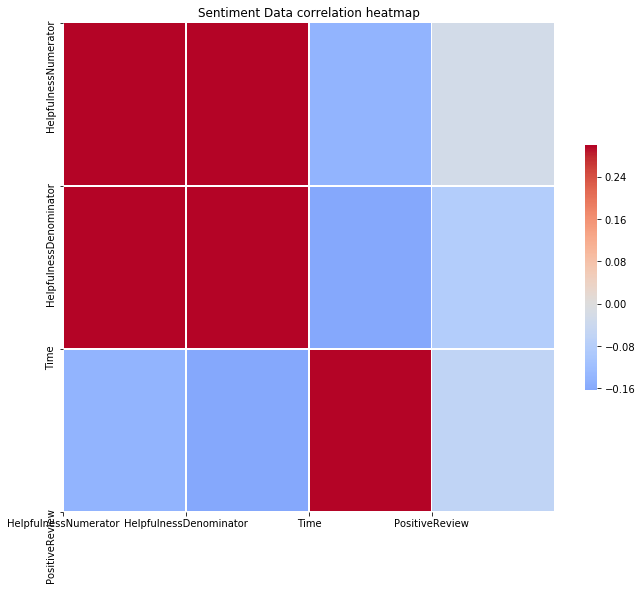

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql.types import FloatType, IntegerType

%matplotlib inline

pdf = reviews[['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time','PositiveReview']].as_data_frame()
corr = pdf.corr()

ticks = [i for i in range(len(corr.columns))]
# Generate a mask for the upper triangle

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Color Scheme
cmap = "coolwarm"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(ticks, corr.columns)
plt.yticks(ticks, corr.columns)
plt.title('Sentiment Data correlation heatmap')
plt.show()


## We can see some of our features have decent correlation (remember that we aren't using the reviews yet). Let's try a basic model
### First, let's log some important information in our <code>run</code>
<blockquote>H2O Has a <a href=https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science.html>lot</a> of algorithms, so we'll use a Gradient Boosting Estimator<br>We'll log some things like our feature vector, label, train/test/validation split, training time, and even the model and notebook themselves directly to <a href='/mlflow'>mlflow</a></blockquote>

In [9]:
%%time
from h2o.estimators import H2OGradientBoostingEstimator
from splicemachine.mlflow_support.utilities import get_user

RATIOS = [0.7,0.15]

# Start our run to keep track of important information
mlflow.start_run(run_name='simple_run')

predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

# lp is short for log_param
# lm is short for log_metric
mlflow.lp('predictors', predictors)
mlflow.lp('label', response)
mlflow.lp('source data table', f'{get_user()}.AMAZON_REVIEWS')

# Train Test Split
train,test,valid = reviews.split_frame(ratios=RATIOS)
# Log our ratios
mlflow.lp('ratios',RATIOS)

gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                            stopping_rounds = 5, score_tree_interval = 10,
                                            model_id = "gbm_baseline.hex"
                                           )

mlflow.lp('model_type', gbm_baseline.__class__)

# Code block to time training
with mlflow.timer('train_time'):
    gbm_baseline.train(x = predictors, y = response, 
                       training_frame = train, validation_frame = test
                      )
# Log the model params to mlflow
mlflow.log_params(gbm_baseline.get_params())
# Log the model to MLFlow
mlflow.log_model(gbm_baseline, 'baseline_model')
# Log the training notebook to MLFlow
mlflow.log_artifact('MLManager H2O Demo.ipynb', 'training_notebook')
gbm_baseline

Starting Code Block train_time... gbm Model Build progress: |███████████████████████████████████████████████| 100%
Done.
Code Block train_time:
Ran in 6.196 secs
Ran in 0.103 mins
Saving artifact of size: 1582.229 KB to Splice Machine DB
Saving artifact of size: 790.302 KB to Splice Machine DB
CPU times: user 590 ms, sys: 112 ms, total: 701 ms
Wall time: 9.85 s
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_baseline.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,25639.0,5.0,5.0,5.0,17.0,32.0,29.96




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13621599071684365
RMSE: 0.36907450564465116
LogLoss: 0.43573871604371306
Mean Per-Class Error: 0.30294909803326386
AUC: 0.7651849136166377
AUCPR: 0.9060825299118951
Gini: 0.5303698272332753

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5351257536653036: 


,,0,1,Error,Rate
0,0,4329.0,11053.0,0.7186,(11053.0/15382.0)
1,1,1489.0,53198.0,0.0272,(1489.0/54687.0)
2,Total,5818.0,64251.0,0.179,(12542.0/70069.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.535126,0.894550,263.0
1,max f2,0.233941,0.949338,352.0
2,max f0point5,0.744480,0.866401,174.0
3,max accuracy,0.600052,0.821761,238.0
4,max precision,0.961058,1.000000,0.0
5,max recall,0.082435,1.000000,395.0
6,max specificity,0.961058,1.000000,0.0
7,max absolute_mcc,0.687098,0.404484,198.0
8,max min_per_class_accuracy,0.812741,0.686452,121.0
9,max mean_per_class_accuracy,0.789146,0.697051,144.0



Gains/Lift Table: Avg response rate: 78.05 %, avg score: 78.04 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010104,0.924989,1.252318,1.252318,0.977401,0.932727,0.977401,0.932727,0.012654,0.012654,25.231810,25.231810
1,,2,0.020009,0.918158,1.257273,1.254771,0.981268,0.921049,0.979315,0.926947,0.012453,0.025107,25.727263,25.477063
2,,3,0.030013,0.912926,1.241062,1.250201,0.968616,0.915329,0.975749,0.923074,0.012416,0.037523,24.106228,25.020118
3,,4,0.040003,0.909535,1.233683,1.246076,0.962857,0.911191,0.972529,0.920107,0.012325,0.049847,23.368327,24.607612
4,,5,0.050022,0.906824,1.231994,1.243256,0.961538,0.908034,0.970328,0.917689,0.012343,0.062190,23.199368,24.325562
5,,6,0.100558,0.898139,1.181768,1.212355,0.922338,0.902074,0.946211,0.909841,0.059722,0.121912,18.176758,21.235452
6,,7,0.150009,0.890913,1.185132,1.203380,0.924964,0.894299,0.939207,0.904718,0.058606,0.180518,18.513170,20.338039
7,,8,0.200046,0.879700,1.181871,1.198000,0.922419,0.885376,0.935007,0.899880,0.059137,0.239655,18.187058,19.800025
8,,9,0.300019,0.862340,1.147384,1.181134,0.895503,0.870691,0.921844,0.890153,0.114707,0.354362,14.738447,18.113394
9,,10,0.400006,0.840339,1.126555,1.167491,0.879246,0.850196,0.911196,0.880166,0.112641,0.467003,12.655500,16.749116




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14010161942162935
RMSE: 0.37430150870872714
LogLoss: 0.44731859995415363
Mean Per-Class Error: 0.33506928943763836
AUC: 0.7253435703790653
AUCPR: 0.8884157242391383
Gini: 0.45068714075813054

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5293909234372814: 


,,0,1,Error,Rate
0,0,815.0,2394.0,0.746,(2394.0/3209.0)
1,1,351.0,11467.0,0.0297,(351.0/11818.0)
2,Total,1166.0,13861.0,0.1827,(2745.0/15027.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.529391,0.893103,270.0
1,max f2,0.223306,0.950538,361.0
2,max f0point5,0.676740,0.861144,207.0
3,max accuracy,0.547632,0.817795,264.0
4,max precision,0.955967,1.000000,0.0
5,max recall,0.100830,1.000000,394.0
6,max specificity,0.955967,1.000000,0.0
7,max absolute_mcc,0.628474,0.363205,227.0
8,max min_per_class_accuracy,0.815424,0.650670,122.0
9,max mean_per_class_accuracy,0.758485,0.664931,171.0



Gains/Lift Table: Avg response rate: 78.65 %, avg score: 78.26 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010248,0.925587,1.180711,1.180711,0.928571,0.932862,0.928571,0.932862,0.012100,0.012100,18.071102,18.071102
1,,2,0.020031,0.918965,1.159086,1.170150,0.911565,0.921641,0.920266,0.927382,0.011339,0.023439,15.908628,17.015010
2,,3,0.030013,0.914012,1.229150,1.189773,0.966667,0.916564,0.935698,0.923784,0.012269,0.035708,22.915045,18.977328
3,,4,0.040061,0.910137,1.187327,1.189160,0.933775,0.911782,0.935216,0.920773,0.011931,0.047639,18.732733,18.915976
4,,5,0.050043,0.907199,1.186766,1.188682,0.933333,0.908498,0.934840,0.918325,0.011846,0.059486,18.676595,18.868227
5,,6,0.100020,0.898441,1.169948,1.179321,0.920107,0.902651,0.927478,0.910493,0.058470,0.117956,16.994760,17.932117
6,,7,0.149997,0.891179,1.171641,1.176762,0.921438,0.894593,0.925466,0.905196,0.058555,0.176510,17.164072,17.676216
7,,8,0.200173,0.880322,1.113015,1.160783,0.875332,0.885700,0.912899,0.900309,0.055847,0.232357,11.301467,16.078290
8,,9,0.300060,0.862415,1.128371,1.149993,0.887408,0.870917,0.904413,0.890524,0.112709,0.345067,12.837079,14.999324
9,,10,0.400013,0.841646,1.098836,1.137210,0.864181,0.850913,0.894360,0.880627,0.109832,0.454899,9.883646,13.721043




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-06-03 01:33:00,0.299 sec,0.0,0.413926,0.526308,0.500000,0.000000,1.000000,0.219526,0.409855,0.518726,0.500000,0.000000,1.000000,0.213549
1,,2020-06-03 01:33:02,2.097 sec,10.0,0.386435,0.470508,0.722491,0.884999,1.227059,0.188900,0.385758,0.469681,0.705835,0.878798,1.157423,0.189858
2,,2020-06-03 01:33:03,3.070 sec,20.0,0.377717,0.453923,0.734573,0.889451,1.237656,0.184432,0.378298,0.455566,0.716284,0.883222,1.163496,0.184668
3,,2020-06-03 01:33:04,3.858 sec,30.0,0.373774,0.445501,0.748326,0.898008,1.248373,0.182235,0.375929,0.450681,0.721199,0.886699,1.162785,0.185200
4,,2020-06-03 01:33:04,4.468 sec,40.0,0.371823,0.441510,0.753473,0.900183,1.244874,0.180736,0.374793,0.448388,0.723046,0.887753,1.180711,0.185000
5,,2020-06-03 01:33:05,4.935 sec,50.0,0.369075,0.435739,0.765185,0.906083,1.252318,0.178995,0.374302,0.447319,0.725344,0.888416,1.180711,0.182671



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,HelpfulnessNumerator,5348.876465,1.000000,0.421513
1,HelpfulnessDenominator,4189.913086,0.783326,0.330182
2,Time,1458.333862,0.272643,0.114922
3,ProductId,1350.541504,0.252491,0.106428
4,UserId,342.052032,0.063948,0.026955


## You can see above that H2O gives you loads of details about your model. Let's inspect it a bit more and log some results to MLFlow

In [10]:
%matplotlib inline  

# Print and Log Model params
params = dict(zip(gbm_baseline.summary().col_header[1:],
                    gbm_baseline.summary().cell_values[0][1:]))
print(gbm_baseline.summary())
mlflow.log_params(params)



Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,25639.0,5.0,5.0,5.0,17.0,32.0,29.96


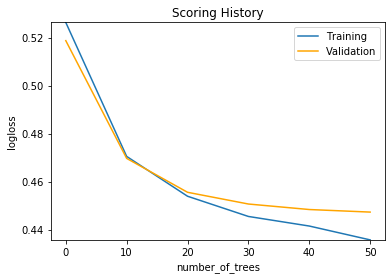

AUC on Validation Data: 0.725


In [11]:
from IPython.core.display import HTML
#Plot and Log Scoring history
gbm_baseline.plot()
print("AUC on Validation Data: " + str(round(gbm_baseline.auc(valid = True), 3)))
# Log training and validation metrics over time
for step, row in gbm_baseline.scoring_history().iterrows():
    row_dict = row.to_dict()
    for r in row_dict:
        if 'train' in r or 'valid' in r:
            mlflow.log_metric(r, row_dict[r],step=step)

cur_run = mlflow.current_run_id()
cur_exp = mlflow.current_exp_id()
link = f'/mlflow/#/metric/training_auc?runs=["{cur_run}"]&experiment={cur_exp}&plot_metric_keys=["training_logloss",\"validation_logloss\",\"training_rmse\",\"validation_rmse\"]'
HTML(f'<font size="+2">See your metrics plot <a href={link}>here</a></font>') 



In [12]:
# Print and Log Confusion Matrix
print(gbm_baseline.confusion_matrix(valid = True))
mlflow.lm('fpr', gbm_baseline.fpr(valid=True)[0][0])
mlflow.lm('tpr', gbm_baseline.tpr(valid=True)[0][0])
mlflow.lm('fnr', gbm_baseline.fnr(valid=True)[0][0])
mlflow.lm('tnr', gbm_baseline.fnr(valid=True)[0][0])
mlflow.lm('F0point5', gbm_baseline.F0point5(valid=True)[0][1])
mlflow.lm('F1', gbm_baseline.F1(valid=True)[0][1])
mlflow.lm('F2', gbm_baseline.F2(valid=True)[0][1])
mlflow.lm('auc', gbm_baseline.auc(valid = True))
mlflow.lp('threshold', gbm_baseline.F1(valid=True)[0][0]) # First element is the threshold


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5293909234372814: 


,,0,1,Error,Rate
0,0,815.0,2394.0,0.746,(2394.0/3209.0)
1,1,351.0,11467.0,0.0297,(351.0/11818.0)
2,Total,1166.0,13861.0,0.1827,(2745.0/15027.0)


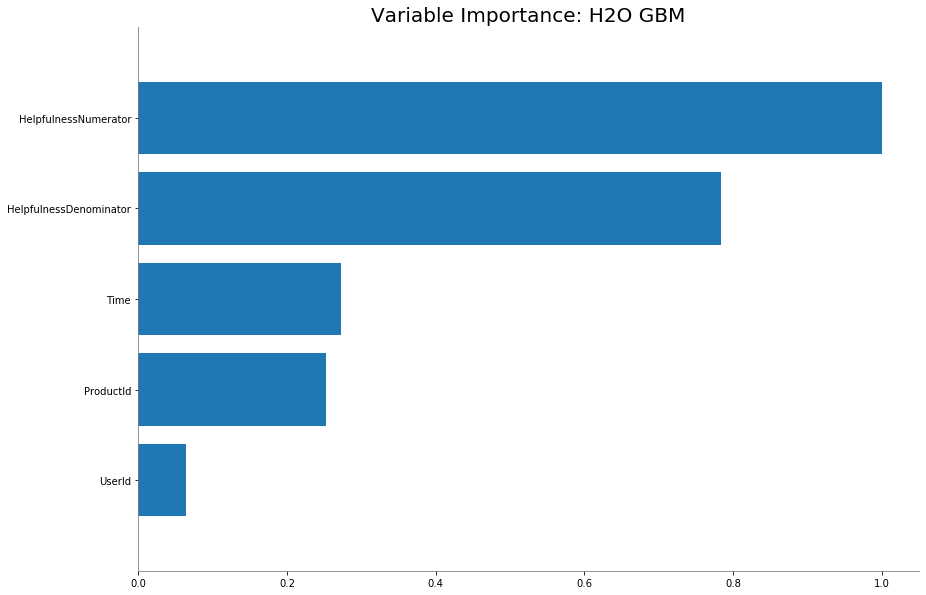

In [13]:
# Plot and Log Variable Importance
gbm_baseline.varimp_plot()
for var in gbm_baseline.varimp():
    mlflow.lm(f'varimp_{var[0]}',var[-1])

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


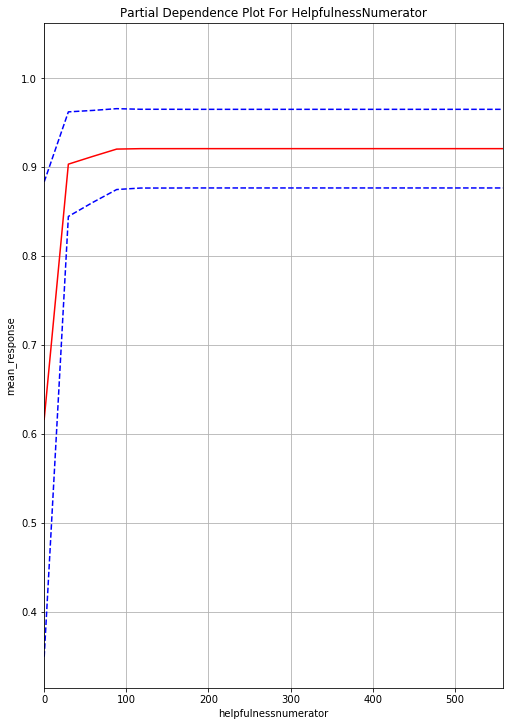

In [14]:
# Partial Dependence Plot
pdp_helpfulness = gbm_baseline.partial_plot(train, cols = ["HelpfulnessNumerator"])

In [15]:
mlflow.end_run()

# There is room for improvement 
## Let's now Tokenize words in the Review
### But first, let's start our new run

In [16]:
import pandas as pd
# Start new mlflow run
mlflow.start_run(run_name='review_tokenizer')
mlflow.lp('source data table', f'{get_user()}.AMAZON_REVIEWS')
# Get common stop words from H2O
data_path = "https://splice-demo.s3.amazonaws.com/stop_words.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])
print(STOP_WORDS)

['all', 'just', 'being', 'over', 'both', 'through', 'yourselves', 'its', 'before', 'o', 'hadn', 'herself', 'll', 'had', 'should', 'to', 'only', 'won', 'under', 'ours', 'has', 'do', 'them', 'his', 'very', 'they', 'not', 'during', 'now', 'him', 'nor', 'd', 'did', 'didn', 'this', 'she', 'each', 'further', 'where', 'few', 'because', 'doing', 'some', 'hasn', 'are', 'our', 'ourselves', 'out', 'what', 'for', 'while', 're', 'does', 'above', 'between', 'mustn', 't', 'be', 'we', 'who', 'were', 'here', 'shouldn', 'hers', 'by', 'on', 'about', 'couldn', 'of', 'against', 's', 'isn', 'or', 'own', 'into', 'yourself', 'down', 'mightn', 'wasn', 'your', 'from', 'her', 'their', 'aren', 'there', 'been', 'whom', 'too', 'wouldn', 'themselves', 'weren', 'was', 'until', 'more', 'himself', 'that', 'but', 'don', 'with', 'than', 'those', 'he', 'me', 'myself', 'ma', 'these', 'up', 'will', 'below', 'ain', 'can', 'theirs', 'my', 'and', 've', 'then', 'is', 'am', 'it', 'doesn', 'an', 'as', 'itself', 'at', 'have', 'in'

In [17]:
# Inspect our reviews before tokenization
reviews['Text']

Text
"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"
"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)<br /><br />They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats."
We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.
"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!"
"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.<br /><br />The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.<br /><br />If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amounts or much direction. In comparison, the Annie Chun's package gives clear, specific directions on rice noodle preparation and two recipes.<br /><br />I use rice noodles = maifun = rice sticks = sometimes called vermicelli for making the Vietnamese salad ""bun tofu"", to serve with stir-fried veggies or in lettuce rolls. They can also be used in spring rolls/egg rolls. When cooking with thin rice noodles, be careful not to oversoak/overcook/overmix or they tend to disintegrate. Asian rice noodle vermicelli (maifun) are not the same as Italian vermicelli and are not readily interchangeable. If making an Italian recipe, the best results would be expected from Italian pasta and not maifun.<br /><br />A few final notes... Both Peacock and Annie Chun's brown rice noodles are gluten free. T

## Now we can train our Word2Vec model
<blockquote>We are going to use the popular Gensim word2vec implementation for scikit-learn. We use scikit-learn here because of it's implementation of <code>Pipelines</code> which allow us to create custom transformations on the data before training/running our model. This gives us the ultimate flexibility. We can also time how long it takes to train the word vectorizer, and log the vector size so we can change it and see how performance changes. Then we can look at some word synonyms to see how well the tokenizer did</i></br><footer>Splice Machine</footer></blockquote><br>

In [18]:
def tokenize( reviews ):
    review_tokens = []
    for review in reviews[0]:
        # Remove non-letters
        review = re.sub("[^a-zA-Z]"," ", review)
        review = review.lower().split()

        stops = set(STOP_WORDS)
        review = [w for w in review if w not in stops]
        review_tokens.append(review)
    return(review_tokens)

In [10]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [19]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline as skPipe
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from gensim.sklearn_api import W2VTransformer, D2VTransformer
import pandas as pd

pdf = reviews['Text'].as_data_frame().astype('string')

word2vec_model = skPipe(verbose=True,
                            steps = [
                                ('preprocessor', FunctionTransformer(tokenize, validate=False)),
                                ('word2vec', D2VTransformer()),
                                ('postprocessor', FunctionTransformer(lambda X: X.astype('double')))
                            ])
with mlflow.timer('word2vec_train_time'):
    # tokenize and build vocab
    word2vec_model.fit([pdf.dropna()['Text']])

The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.


Starting Code Block word2vec_train_time... [Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   4.7s
[Pipeline] .......... (step 2 of 3) Processing word2vec, total= 1.9min


The default validate=True will be replaced by validate=False in 0.22.


[Pipeline] ..... (step 3 of 3) Processing postprocessor, total=   0.0s
Done.
Code Block word2vec_train_time:
Ran in 116.892 secs
Ran in 1.948 mins


## Now we can use the Doc2Vec Model to see the most similar sentences of an input

In [22]:
from copy import deepcopy
doc2vec_model = deepcopy(word2vec_model.steps[1][1].gensim_model)

# Tokenize our input
inp = "Tastes like Earl Grey, but it's green tea so it's healthier."
tokens = tokenize([[inp]])
new_vector = doc2vec_model.infer_vector(tokens[0])
# Get our vectorized sentence
sims = doc2vec_model.docvecs.most_similar([new_vector])
print(f'Vector of input: {sims}\n')
# Get the most similar review
index = sims[0][0]
output = pdf.dropna()['Text'].iloc[index]

print(f'Input: {inp}\nOutput: {output}')

Vector of input: [(97666, 0.4205482006072998), (89475, 0.3980906903743744), (93814, 0.3940778076648712), (17113, 0.385466992855072), (27381, 0.38422274589538574), (14167, 0.37888938188552856), (30906, 0.3760056495666504), (13332, 0.3750417232513428), (1222, 0.3709920644760132), (62971, 0.36697107553482056)]

Input: Tastes like Earl Grey, but it's green tea so it's healthier.
Output: I made macarons with these; the almond flour is very finely ground and perfectly suited for macaron-making!


In [24]:
import sys
mlflow.end_run()
mlflow.start_run()
schema = 'REPLACE_ME_DBSCHEMA'
splice._dropTableIfExists(f'{schema}.sk_vec_pipe')
splice._dropTableIfExists(f'{schema}.sk_vec_pipe_preds')
mlflow.deploy_db(word2vec_model, pdf, schema, 'sk_vec_pipe', [('MOMENT_KEY', 'INT')], run_id=mlflow.current_run_id(),
                     classes = [f'C{i+1}' for i in range(100)], verbose=True)

Saving model of size: 49232.019 KB to Splice Machine DB
Prediction labels found. Using ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C100'] as labels for predictions [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,

In [26]:
%%sql

insert into sk_vec_pipe values('I really liked this coffee. I recommend!', 2);
select * from sk_vec_pipe_preds;


## Now we can save this model and end our run
<blockquote>We want to save this vectorizer as an <b>independent</b> <code>run</code>. This is because we may want to build more than 1 model that utilizes these word vectors. We don't want to duplicate those identical word vectors, so we can use the outputs for <b>more than one model</b>. This is the idea of a <i>feature store</i> where we use features from one dataset on multiple models. This is crucial to creating efficient ML workflow systems.

In [28]:
mlflow.log_model(word2vec_model, 'word2vec_model')
mlflow.lp('vector_size',100)
mlflow.end_run()

Saving artifact of size: 49232.019 KB to Splice Machine DB


## Let's vectorize our reviews
<blockquote>Now that we have a word embedding for each word in our vocabulary, we will aggregate the words for each review using the <code>transform</code> function.  This will give us one aggregated word embedding for each review.</blockquote>

In [30]:
# Calculate a vector for each review
review_vecs = h2o.H2OFrame(word2vec_model.transform([pdf.fillna("")['Text']]))
# Add the review vectors to the original dataframe
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)
ext_reviews.head()

The default validate=True will be replaced by validate=False in 0.22.


Parse progress: |█████████████████████████████████████████████████████████| 100%


ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,-0.00133612,0.00147022,0.00489118,-0.000812136,-0.00485834,-0.00096183,-0.000388682,0.00303393,-0.00361697,0.00307536,-0.00387981,0.00410081,-0.004984,0.0047441,-0.00031778,0.00209467,0.0014758,-0.00120933,0.0047215,0.0016437,-0.00454923,-0.00384956,0.000442707,0.003925,0.00152025,0.00254895,0.000114834,0.00252259,0.0012479,-0.00303425,-0.00091658,-0.00284571,0.000826418,-0.00438576,0.000907566,0.000468217,-0.00364127,0.00203741,-0.00200908,-0.00107813,0.00164739,-0.0020164,0.00389483,-0.00281134,0.00082546,-0.0019652,0.0033707,-0.00118207,-0.00176637,0.00377917,-0.00494846,0.000215452,0.00106531,0.000204757,-0.000434755,0.000962922,-0.00171811,-0.0038728,-0.00498921,-0.00315165,0.00200525,0.00415614,0.00067918,-0.00375062,0.00112005,-0.0043547,-0.00252379,0.00269816,-0.00406649,0.004808,-0.00021671,-0.00499647,-0.000111112,0.00341148,0.00332737,-0.00494905,0.000501786,-0.00410729,-0.00159208,-0.000411889,0.00362065,0.0037789,-0.00347411,0.00437522,-0.00145569,0.000228353,-0.00341161,-0.00488238,0.00195579,-0.00290785,-0.00302468,0.00458038,0.00488747,0.000711441,-0.00188029,0.00468673,-0.00309895,0.00455,0.00236985,0.000381572
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,-0.00423355,0.00433418,-0.00481421,4.24921e-05,-0.00155022,0.001619,-0.00281991,0.00124699,0.00182601,0.00238784,-0.000447347,0.00418661,-0.00295085,0.00359459,-0.00123096,-0.00201871,0.00152987,0.00467554,-0.000164307,-0.00327224,-0.00194678,0.000861934,-0.00120003,-0.000825984,-0.00186494,0.00421304,0.0044746,-0.00211432,-0.00440828,-0.0017909,-0.0015314,0.00283345,0.00310395,0.00403174,-0.00489491,0.00213809,0.000913146,-0.00238531,0.00387899,-0.00458897,-0.00133196,0.00261265,0.00196682,0.00345367,0.00218583,0.000903332,0.00294384,0.00129102,-0.00047666,0.00222886,-0.00331657,0.00278342,-0.00271497,-0.0046595,-0.0046353,0.00386287,-0.00114053,-0.00426029,0.00261225,0.00127662,0.00319961,0.0040739,-0.00304281,-0.00283115,-0.00149188,-0.00360352,0.000537949,0.00416024,0.00227099,0.000753228,-0.00353955,0.00195869,0.00126945,-0.00219305,0.00383016,0.00258473,-0.00470925,-0.000743051,-0.00449109,-0.000955942,0.00494278,0.00028845,-0.00149227,-0.00181637,0.00356655,0.00393856,-0.000792113,-0.00436264,0.000950215,0.00213895,-0.000311588,-0.00392099,-0.00155748,-0.00245845,-0.00485048,0.00354392,0.00365414,-0.00252022,-0.00360211,-0.00317446
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,0.00218472,-0.0048684,0.00114528,0.00426338,0.000614743,0.00313093,-0.000674778,0.00122496,-0.00253126,0.00267866,0.00328795,0.0017330

## Model 2: GBM with Review vectors
<blockquote>
    Now we can train a GBM like before, but include the review vectors. This should hopefully increase improvement! We'll log everything to mlflow so we can compare the results.
    </i></br><footer>Splice Machine</footer></blockquote><br>

In [31]:
from h2o.estimators import H2OGradientBoostingEstimator
mlflow.end_run()
mlflow.start_run(run_name='GBM with word vectors')
RATIOS = [0.7,0.15]
# Train Test Split
ext_train,ext_test,ext_valid = ext_reviews.split_frame(ratios=RATIOS)
# Log our ratios
mlflow.lp('ratios',RATIOS)
# Log what word vectors we're using
mlflow.lp('word vectors', 'reviews')

non_token_predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
predictors = non_token_predictors + review_vecs.names
response = 'PositiveReview'

mlflow.lp('label', response)
# There are a lot of predictors here (C1-C100 + features) so let's shorten that
mlflow.lp('predictors', non_token_predictors + [f'C1-C{len(review_vecs.columns)}'])

gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
with mlflow.timer('train_time'):
    gbm_embeddings.train(x = predictors, y = response, 
                       training_frame = ext_train, validation_frame = ext_test
                      )

# Log the model params to mlflow
mlflow.log_params(gbm_embeddings.get_params())
# Log the model to MLFlow
mlflow.log_model(gbm_embeddings, 'baseline_model')
# Log the training notebook to MLFlow
mlflow.log_artifact('MLManager H2O Demo.ipynb', 'training_notebook')
gbm_embeddings

Starting Code Block train_time... gbm Model Build progress: |███████████████████████████████████████████████| 100%
Done.
Code Block train_time:
Ran in 10.978 secs
Ran in 0.183 mins
Saving artifact of size: 1593.21 KB to Splice Machine DB
Saving artifact of size: 761.135 KB to Splice Machine DB
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_embeddings.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22697.0,5.0,5.0,5.0,20.0,32.0,29.4




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13669621832053175
RMSE: 0.36972451679667084
LogLoss: 0.4370177188419529
Mean Per-Class Error: 0.29930198463142377
AUC: 0.7679606603316217
AUCPR: 0.9089462147440353
Gini: 0.5359213206632434

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5280522001695236: 


,,0,1,Error,Rate
0,0,4052.0,11331.0,0.7366,(11331.0/15383.0)
1,1,1268.0,53408.0,0.0232,(1268.0/54676.0)
2,Total,5320.0,64739.0,0.1798,(12599.0/70059.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.528052,0.894494,271.0
1,max f2,0.288617,0.949583,346.0
2,max f0point5,0.762155,0.866466,163.0
3,max accuracy,0.603146,0.821679,241.0
4,max precision,0.944390,1.000000,0.0
5,max recall,0.113336,1.000000,394.0
6,max specificity,0.944390,1.000000,0.0
7,max absolute_mcc,0.624071,0.399899,231.0
8,max min_per_class_accuracy,0.809620,0.690230,120.0
9,max mean_per_class_accuracy,0.789365,0.700698,141.0



Gains/Lift Table: Avg response rate: 78.04 %, avg score: 78.03 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010006,0.919004,1.266725,1.266725,0.988588,0.924269,0.988588,0.924269,0.012675,0.012675,26.672522,26.672522
1,,2,0.020012,0.913625,1.263069,1.264897,0.985735,0.916089,0.987161,0.920179,0.012638,0.025313,26.306944,26.489733
2,,3,0.030003,0.909859,1.250230,1.260013,0.975714,0.911638,0.983349,0.917335,0.012492,0.037805,25.022985,26.001282
3,,4,0.040009,0.906811,1.239307,1.254834,0.967190,0.908263,0.979308,0.915066,0.012400,0.050205,23.930692,25.483450
4,,5,0.050001,0.904326,1.226433,1.249159,0.957143,0.905560,0.974879,0.913167,0.012254,0.062459,22.643338,24.915914
5,,6,0.100001,0.895037,1.221725,1.235442,0.953468,0.899514,0.964174,0.906340,0.061087,0.123546,22.172519,23.544217
6,,7,0.150002,0.885746,1.174905,1.215263,0.916928,0.890542,0.948425,0.901074,0.058746,0.182292,17.490458,21.526297
7,,8,0.200003,0.873932,1.163565,1.202339,0.908079,0.879782,0.938339,0.895751,0.058179,0.240471,16.356522,20.233853
8,,9,0.300004,0.854273,1.129364,1.178014,0.881387,0.864369,0.919355,0.885291,0.112938,0.353409,12.936423,17.801377
9,,10,0.400006,0.836782,1.130644,1.166171,0.882387,0.844537,0.910113,0.875102,0.113066,0.466475,13.064448,16.617144




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14054661136213017
RMSE: 0.3748954672467116
LogLoss: 0.4483687236302639
Mean Per-Class Error: 0.331998847835558
AUC: 0.728196521460703
AUCPR: 0.8904505504804234
Gini: 0.45639304292140603

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49490480134763554: 


,,0,1,Error,Rate
0,0,708.0,2521.0,0.7807,(2521.0/3229.0)
1,1,239.0,11561.0,0.0203,(239.0/11800.0)
2,Total,947.0,14082.0,0.1836,(2760.0/15029.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.494905,0.893362,289.0
1,max f2,0.312893,0.950142,344.0
2,max f0point5,0.677169,0.861371,212.0
3,max accuracy,0.500695,0.816422,287.0
4,max precision,0.937212,1.000000,0.0
5,max recall,0.125426,1.000000,394.0
6,max specificity,0.937212,1.000000,0.0
7,max absolute_mcc,0.646052,0.368538,226.0
8,max min_per_class_accuracy,0.811804,0.659237,123.0
9,max mean_per_class_accuracy,0.777946,0.668001,160.0



Gains/Lift Table: Avg response rate: 78.51 %, avg score: 78.14 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010047,0.917400,1.223036,1.223036,0.960265,0.922788,0.960265,0.922788,0.012288,0.012288,22.303569,22.303569
1,,2,0.020028,0.912478,1.256662,1.239793,0.986667,0.914709,0.973422,0.918762,0.012542,0.024831,25.666215,23.979306
2,,3,0.030009,0.908885,1.188734,1.222811,0.933333,0.910582,0.960089,0.916042,0.011864,0.036695,18.873446,22.281127
3,,4,0.040056,0.906014,1.180862,1.212289,0.927152,0.907413,0.951827,0.913877,0.011864,0.048559,18.086205,21.228912
4,,5,0.050037,0.903703,1.163262,1.202510,0.913333,0.904880,0.944149,0.912082,0.011610,0.060169,16.326158,20.250969
5,,6,0.100007,0.894705,1.183760,1.193141,0.929427,0.899210,0.936793,0.905651,0.059153,0.119322,18.375973,19.314095
6,,7,0.150043,0.885103,1.144925,1.177062,0.898936,0.890021,0.924169,0.900438,0.057288,0.176610,14.492472,17.706175
7,,8,0.200013,0.873738,1.126098,1.164329,0.884154,0.879396,0.914172,0.895181,0.056271,0.232881,12.609808,16.432931
8,,9,0.300020,0.853326,1.121959,1.150206,0.880905,0.864111,0.903083,0.884824,0.112203,0.345085,12.195925,15.020595
9,,10,0.400027,0.836279,1.088911,1.134882,0.854957,0.844007,0.891051,0.874620,0.108898,0.453983,8.891060,13.488211




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-06-03 01:47:34,0.821 sec,0.0,0.413957,0.526366,0.500000,0.000000,1.000000,0.219572,0.410746,0.520379,0.500000,0.000000,1.000000,0.214851
1,,2020-06-03 01:47:36,2.828 sec,10.0,0.386418,0.470391,0.723534,0.887080,1.233606,0.190211,0.384600,0.467335,0.717767,0.885046,1.198281,0.191563
2,,2020-06-03 01:47:38,4.686 sec,20.0,0.378116,0.454396,0.736033,0.892522,1.241505,0.185101,0.377888,0.454646,0.720757,0.885553,1.211134,0.185308
3,,2020-06-03 01:47:40,6.508 sec,30.0,0.374486,0.447258,0.743641,0.896566,1.259414,0.183403,0.375966,0.450893,0.723132,0.886708,1.197732,0.184177
4,,2020-06-03 01:47:42,8.290 sec,40.0,0.371936,0.441814,0.755149,0.902679,1.259414,0.180705,0.375288,0.449365,0.724709,0.888470,1.206166,0.183911
5,,2020-06-03 01:47:44,9.969 sec,50.0,0.369725,0.437018,0.767961,0.908946,1.266725,0.179834,0.374895,0.448369,0.728197,0.890451,1.223036,0.183645



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,HelpfulnessNumerator,4623.907715,1.000000,0.369515
1,HelpfulnessDenominator,4366.922363,0.944422,0.348978
2,Time,1330.391357,0.287720,0.106317
3,ProductId,428.513885,0.092674,0.034244
4,UserId,120.660072,0.026095,0.009642
5,C59,52.431252,0.011339,0.004190
6,C79,35.146072,0.007601,0.002809
7,C10,34.029274,0.007359,0.002719
8,C38,32.917484,0.007119,0.002631
9,C5,32.728588,0.007078,0.002615



See the whole table with table.as_data_frame()


## Just like before, let's log all of our outcomes


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22697.0,5.0,5.0,5.0,20.0,32.0,29.4


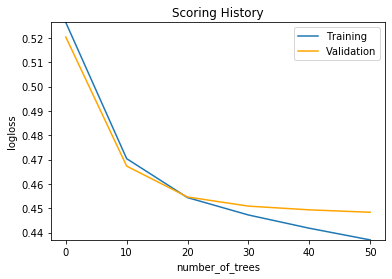

AUC on Validation Data: 0.728

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49490480134763554: 


,,0,1,Error,Rate
0,0,708.0,2521.0,0.7807,(2521.0/3229.0)
1,1,239.0,11561.0,0.0203,(239.0/11800.0)
2,Total,947.0,14082.0,0.1836,(2760.0/15029.0)


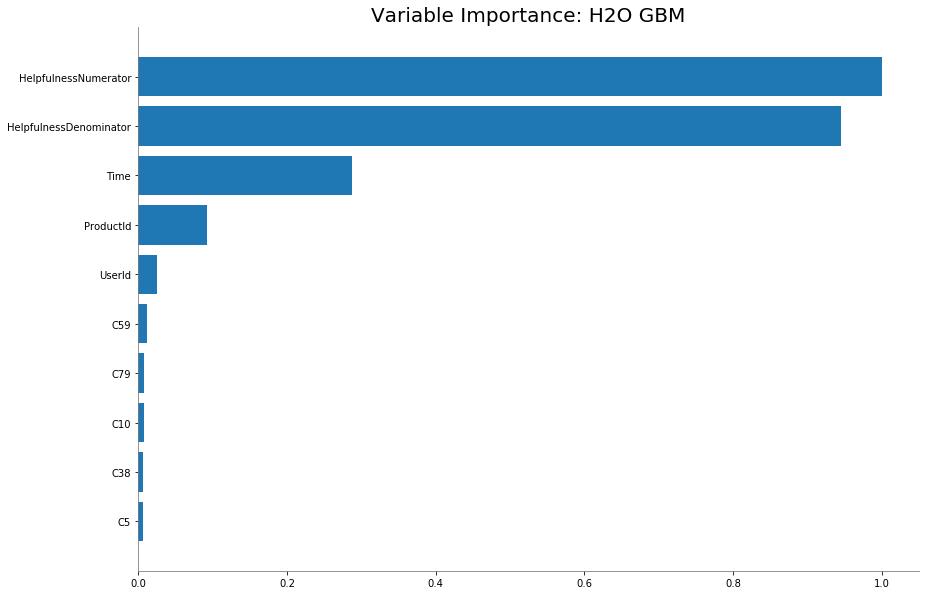

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


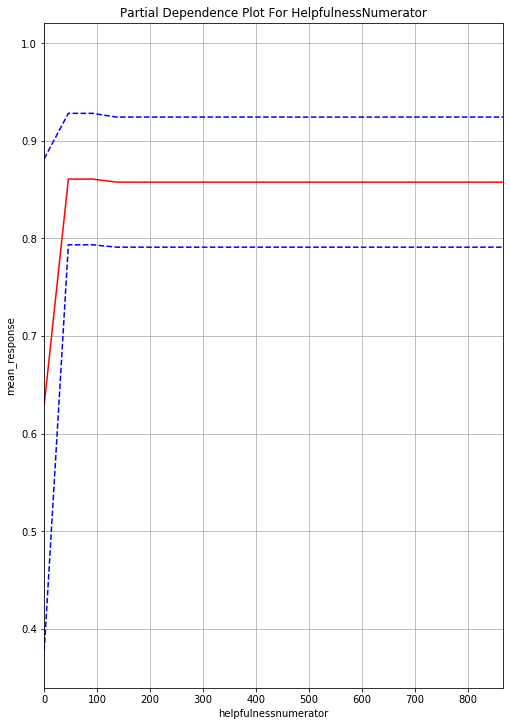

In [32]:
%matplotlib inline  
from IPython.core.display import HTML

# Print and Log Model params
params = dict(zip(gbm_embeddings.summary().col_header[1:],
                    gbm_embeddings.summary().cell_values[0][1:]))
print(gbm_embeddings.summary())
mlflow.log_params(params)


#Plot and Log Scoring history
gbm_embeddings.plot()
print("AUC on Validation Data: " + str(round(gbm_embeddings.auc(valid = True), 3)))
# Log training and validation metrics over time
for step, row in gbm_embeddings.scoring_history().iterrows():
    row_dict = row.to_dict()
    for r in row_dict:
        if 'train' in r or 'valid' in r:
            mlflow.log_metric(r, row_dict[r],step=step)


# Print and Log Confusion Matrix
print(gbm_embeddings.confusion_matrix(valid = True))
mlflow.lm('fpr', gbm_embeddings.fpr(valid=True)[0][0])
mlflow.lm('tpr', gbm_embeddings.tpr(valid=True)[0][0])
mlflow.lm('fnr', gbm_embeddings.fnr(valid=True)[0][0])
mlflow.lm('tnr', gbm_embeddings.fnr(valid=True)[0][0])
mlflow.lm('F0point5', gbm_embeddings.F0point5(valid=True)[0][1])
mlflow.lm('F1', gbm_embeddings.F1(valid=True)[0][1])
mlflow.lm('F2', gbm_embeddings.F2(valid=True)[0][1])
mlflow.lm('auc', gbm_embeddings.auc(valid = True))
mlflow.lp('threshold', gbm_embeddings.F1(valid=True)[0][0]) # First element is the threshold


# Plot and Log Variable Importance
gbm_embeddings.varimp_plot()
for var in gbm_embeddings.varimp():
    mlflow.lm(f'varimp_{var[0]}',var[-1])
    
    
# Partial Dependence Plot
pdp_helpfulness = gbm_embeddings.partial_plot(ext_train, cols = ["HelpfulnessNumerator"])

In [36]:
old_run = cur_run
cur_run = mlflow.current_run_id()
cur_exp = mlflow.current_exp_id()
link = f'/mlflow/#/metric/training_auc?runs=["{cur_run}","{old_run}"]&experiment={cur_exp}&plot_metric_keys=["training_logloss",\"validation_logloss\",\"training_rmse\",\"validation_rmse\"]'
HTML(f'<font size="+1">Compare your 2 runs <a href={link}>here</a></font>') 

In [37]:
gbm_embeddings.scoring_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-06-03 01:47:34,0.821 sec,0.0,0.413957,0.526366,0.500000,0.000000,1.000000,0.219572,0.410746,0.520379,0.500000,0.000000,1.000000,0.214851
1,,2020-06-03 01:47:36,2.828 sec,10.0,0.386418,0.470391,0.723534,0.887080,1.233606,0.190211,0.384600,0.467335,0.717767,0.885046,1.198281,0.191563
2,,2020-06-03 01:47:38,4.686 sec,20.0,0.378116,0.454396,0.736033,0.892522,1.241505,0.185101,0.377888,0.454646,0.720757,0.885553,1.211134,0.185308
3,,2020-06-03 01:47:40,6.508 sec,30.0,0.374486,0.447258,0.743641,0.896566,1.259414,0.183403,0.375966,0.450893,0.723132,0.886708,1.197732,0.184177
4,,2020-06-03 01:47:42,8.290 sec,40.0,0.371936,0.441814,0.755149,0.902679,1.259414,0.180705,0.375288,0.449365,0.724709,0.888470,1.206166,0.183911
5,,2020-06-03 01:47:44,9.969 sec,50.0,0.369725,0.437018,0.767961,0.908946,1.266725,0.179834,0.374895,0.448369,0.728197,0.890451,1.223036,0.183645


In [38]:
mlflow.end_run()

In [39]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))
link = f'/mlflow/#/metric/training_auc?runs=["{cur_run}","{old_run}"]&experiment={cur_exp}&plot_metric_keys=["training_auc",\"validation_auc\",\"training_pr_auc\",\"validation_pr_auc\"]'
HTML(f'See a metrics comparison <a href={link}>here</a>')

Baseline AUC: 0.725
With Embeddings AUC: 0.728


# That's some great imrpovement! So what's next?
<blockquote>We included the customer reviews and developed a better model. We've logged everything to MLFlow for detailed comparisons. Now what?<br>
    Let's deploy our models to production so we can utilize what we've built. First, we'll deploy our word vectorizer model, and then deploy our GBM model. Finally, we'll create a feed from the first model to the second, so we can see the final predictions!
        </i></br><footer>Splice Machine</footer></blockquote><br>
<img src=https://splice-demo.s3.amazonaws.com/H2O+Demo+Model+Diagram.png>

## Step 1: Deploy Word2Vec Model

In [165]:
help(mlflow.deploy_db)

Help on function _deploy_db in module splicemachine.mlflow_support.mlflow_support:

_deploy_db(fittedModel, df, db_schema_name, db_table_name, primary_key, run_id: str = None, classes=None, sklearn_args={}, verbose=False, pred_threshold=None, replace=False) -> None
    Function to deploy a trained (currently Spark, Sklearn or H2O) model to the Database.
    This creates 2 tables: One with the features of the model, and one with the prediction and metadata.
    They are linked with a column called MOMENT_ID
    
    :param fittedModel: (ML pipeline or model) The fitted pipeline to deploy
    :param df: (Spark DF) The dataframe used to train the model
                NOTE: this dataframe should NOT be transformed by the model. The columns in this df are the ones
                that will be used to create the table.
    :param db_schema_name: (str) the schema name to deploy to. If None, the currently set schema will be used.
    :param db_table_name: (str) the table name to deploy to. If

In [181]:
# Get the run_id from the name. Note that multiple runs can have the same name, so this returns a list
run_id = mlflow.get_run_ids_by_name('review_tokenizer')[0]
# Get the model from that run
w2v_model = mlflow.load_model(run_id=run_id, name='review_vectorizer_model')
deploy_df = hc.asSparkFrame(reviews[['Text']]).withColumnRenamed('Text', 'Review')
schema = 'REPLACE_ME_DBSCHEMA'
schema='BEN'
mlflow.deploy_db(w2v_model, deploy_df, schema, 'word_vec_model', [('MOMENT_KEY', 'INT')], run_id=run_id, verbose=True)

Saving model of size: 8014.339 KB to Splice Machine DB
Deploying model b8738905c16c to table BEN.word_vec_model
Creating data table ... 
 CREATE TABLE BEN.word_vec_model (
	Review VARCHAR(5000),	MOMENT_KEY INT,
	PRIMARY KEY(MOMENT_KEY)
)

Done.
Creating prediction table ... 
CREATE TABLE BEN.word_vec_model_PREDS (
        	CUR_USER VARCHAR(50) DEFAULT CURRENT_USER,
        	EVAL_TIME TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        	RUN_ID VARCHAR(50) DEFAULT 'b8738905c16c',
        	MOMENT_KEY INT,
	"C1_C0" DOUBLE,
	"C1_C1" DOUBLE,
	"C1_C2" DOUBLE,
	"C1_C3" DOUBLE,
	"C1_C4" DOUBLE,
	"C1_C5" DOUBLE,
	"C1_C6" DOUBLE,
	"C1_C7" DOUBLE,
	"C1_C8" DOUBLE,
	"C1_C9" DOUBLE,
	"C1_C10" DOUBLE,
	"C1_C11" DOUBLE,
	"C1_C12" DOUBLE,
	"C1_C13" DOUBLE,
	"C1_C14" DOUBLE,
	"C1_C15" DOUBLE,
	"C1_C16" DOUBLE,
	"C1_C17" DOUBLE,
	"C1_C18" DOUBLE,
	"C1_C19" DOUBLE,
	"C1_C20" DOUBLE,
	"C1_C21" DOUBLE,
	"C1_C22" DOUBLE,
	"C1_C23" DOUBLE,
	"C1_C24" DOUBLE,
	"C1_C25" DOUBLE,
	"C1_C26" DOUBLE,
	"C1_C27" DOUBLE,
	"C1_

## Sweet! Let's try it out

In [244]:
row = reviews['Text'][9,:]
row.set_names(['Review'])
print(row)
w2v_model.transform(words, aggregate_method="AVERAGE")

Review
"Tastes like Earl Grey, but it's green tea so it's healthier."


C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.0118207,-0.101889,0.0147137,0.278492,0.0469628,-0.172297,-0.0129039,0.0830429,-0.0914811,0.0574676,-0.0639514,0.120431,-0.0962916,-0.0178387,0.0759381,0.179793,-0.0157825,-0.12134,0.0527563,0.0573318,0.0509253,0.120528,0.15535,-0.0792156,0.0379387,-0.0660397,-0.00495673,-0.079089,-0.0337948,0.0854287,-0.270305,0.14011,0.0664857,-0.0903058,-0.0534608,0.139986,0.114537,-0.0631098,-0.145617,0.00200458,0.195605,-0.12095,0.0142132,0.00382048,0.00467813,-0.0647183,0.12261,0.10863,-0.179427,0.100265,-0.0961187,0.108058,0.0614284,-0.113856,-0.0481913,-0.0260456,0.0346338,0.127268,0.112572,-0.0689213,0.032635,0.1602,-0.0245575,-0.0889716,0.0344523,0.0388336,-0.0977627,0.0664074,-0.0214509,-0.0922424,-0.0759032,0.168529,0.0484152,0.0341554,-0.0530976,0.0814525,0.114328,0.118376,0.0836662,-0.155847,0.0524612,-0.0582578,0.0343186,-0.0191061,0.0982101,-0.0475758,0.00883958,0.159842,-0.0601515,0.0405056,-0.00583725,-0.113468,0.0123878,0.0548682,0.0231149,-0.153038,-0.0830139,0.0517786,-0.167759,0.0590884
-0.0647607,-0.0727755,-0.115707,0.0486232,0.00228006,-0.0894267,-0.0550715,0.0182499,0.104742,0.0961806,-0.0779413,-0.0978953,0.115459,-0.153234,0.0496184,0.168469,-0.0180559,0.122231,0.0145231,0.0172325,-0.0637962,-0.126619,0.15836,-0.0885775,0.0203511,-0.0701156,-0.040133,-0.304234,-0.0746839,-0.0674719,-0.103309,0.0273377,0.108569,0.0180806,-0.0350313,0.21245,0.0424701,-0.126426,-0.0514539,-0.112131,0.0785268,-0.0475902,-0.166364,0.253536,-0.0662786,0.133733,0.139492,0.144991,0.00557501,-0.079479,-0.0282375,-0.0368711,0.0286063,-0.0782206,0.00642933,0.11829,0.00523307,0.0984682,-0.0332558,0.0394351,0.0516561,0.191958,-0.0593793,-0.0620899,0.00285376,0.0289805,-0.0604133,0.0530364,-0.0330077,0.0675788,-0.0419845,0.157696,0.0653407,0.161192,0.0112189,0.111598,0.0453798,0.194989,0.138888,0.0231592,0.00690089,-0.166217,-0.0599659,-0.102449,0.0882302,-0.00776763,0.113629,0.0108894,-0.222703,-0.15212,-0.0933445,-0.0339013,0.0440877,-0.116198,0.00132958,-0.00732167,-0.157039,-0.039421,-0.0166677,-0.0640155
-0.0385096,-0.164311,0.0749115,0.105914,0.0364867,-0.14865,0.0147054,0.0432582,0.0389016,0.0396217,-0.0317641,0.095205,-0.0875548,-0.00580839,0.0605815,0.184019,-0.0828741,-0.075011,0.0940388,0.0624332,-0.0170392,-0.0428544,0.127299,0.0350129,0.0544682,-0.0712631,0.0524339,-0.114599,0.0339514,-0.0160842,-0.206147,-0.0418927,-0.0193752,0.0589492,-0.0550368,0.160735,0.0416373,-0.106153,-0.0952572,-0.0907418,0.140228,-0.141172,-0.0906205,0.172362,-0.0140963,-0.0684992,0.0649892,0.218862,-0.112363,0.0910496,-0.0594554,0.0785124,0.0352732,0.00169446,0.0356621,0.126364,-0.0982795,0.136849,0.0250553,-0.132051,0.0240202,0.0611908,-0.0153794,-0.0686614,-0.0755786,0.070956,-0.0514114,0.101125,-0.0541772,0.0603693,-0.151588,0.118073,0.0864352,0.0697684,0.0771088,0.127461,-0.00255191,0.171573,0.0162494,-0.0422113,-0.0200063,-0.016754,-0.0927813,-0.0477321,-0.0520219,-0.123997,0.147805,0.0895179,-0.0564334,0.0667794,-0.0441478,-0.263763,0.0178793,-0.0385753,0.0908309,-0.213796,-0.0448226,0.0337263,0.0551377,-0.00646082
-0.0335025,-0.104515,0.0670558,0.125524,0.121117,-0.132281,-0.0278141,0.0481801,0.0214209,0.0399683,-0.0675355,0.0613814,-0.0557912,-0.0336307,0.0842112,0.186743,-0.087822,0.00219227,0.108149,-0.00918456,-0.0524869,-0.0394393,0.0391789,0.0445749,0.0390993,-0.0879633,0.00584351,-0.144511,0.0167408,-0.13431,-0.0807045,0.0671659,0.0427141,0.041196,-0.0704532,0.181694,0.0836733,-0.0584921,-0.0831199,0.0848009,0.169781,-0.0153495,-0.190452,0.0853043,0.0573439,-0.0407362,0.107085,0.0810725,-0.200234,0.179503,-0.0225273,0.0183807,0.0216287,0.0350069,0.0458474,0

In [227]:
reviews

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)<br /><br />They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats.",1
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.,1
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!",1
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.<br /><br />The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.<br /><br />If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strip

In [243]:
words[32,:]

C1
everything


In [252]:
from h2o.assembly import *
from h2o.transforms.preprocessing import *

python_list1 = [[4,4,4,4],[4,4,4,4]]
python_list2 = [[2,1,2,2], [2,2,2,2]]

frame1 = h2o.H2OFrame(python_obj=python_list1)
frame2 = h2o.H2OFrame(python_obj=python_list2)

# assembly = H2OAssembly(steps=[]

H2OAssembly.divide(frame1, frame2)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


C1,C2,C3,C4
2,4,2,2
2,2,2,2


In [262]:
from h2o.estimators.word2vec import H2OWord2vecEstimator
help(H2OWord2vecEstimator)

Help on class H2OWord2vecEstimator in module h2o.estimators.word2vec:

class H2OWord2vecEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  H2OWord2vecEstimator(**kwargs)
 |  
 |  Word2Vec
 |  
 |  Method resolution order:
 |      H2OWord2vecEstimator
 |      h2o.estimators.estimator_base.H2OEstimator
 |      h2o.model.model_base.ModelBase
 |      h2o.model.model_base.ModelBase
 |      h2o.base.Keyed
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      Construct a new model instance.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  from_external(external=<class 'h2o.frame.H2OFrame'>)
 |      Creates new H2OWord2vecEstimator based on an external model.
 |      
 |      :param external: H2OFrame with an external model
 |      :return: H2OWord2vecEstimator instance representing the external model
 |      
 |      :examples:
 |      
 |      >>> words = h2o.create_fram

In [291]:
pdf_reviews = review_df.toPandas()

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
fit_count_vect = count_vect.fit(pdf_reviews)

x = fit_count_vect.transform(pdf_reviews.iloc[0])

NameError: name 'pdf_reviews' is not defined

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline as skPipe
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
# #Custom Transformer that extracts columns passed as argument to its constructor 
# class PreProcessor( BaseEstimator, TransformerMixin ):
#     #Class Constructor 
#     def __init__( self ):
#         pass
    
#     #Return self nothing else to do here    
#     def fit( self, X, y = None):
#         return self
    
#     #Method that describes what we need this transformer to do
#     def transform( self, X, y = None ):
#         return X[0]

# #Custom Transformer that extracts columns passed as argument to its constructor 
# class VectorSelector( BaseEstimator, TransformerMixin ):
#     #Class Constructor 
#     def __init__( self ):
#         pass
    
#     #Return self nothing else to do here    
#     def fit( self, X, y = None):
#         return self 
    
#     #Method that describes what we need this transformer to do
#     def transform( self, X, y = None ):
#         return X.toarray()


# def pre_process(X):
#     return X[0]
# def get_vector(X):
#     return X.toarray()
# p = skPipe(steps = [
#     ('preprocessor', FunctionTransformer(pre_process)),
#     ('vectorizer', TfidfVectorizer()),
#     ('vector_returner', FunctionTransformer(get_vector, accept_sparse=True))
# ])

# list of text documents
text = ["The quick brown fox jumped over the lazy dog.",
        "The dog.",
        "The fox"]

p = skPipe(steps = [
    ('preprocessor', FunctionTransformer(lambda x: x[0])),
    ('vectorizer', TfidfVectorizer()),
    ('vector_returner', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
])



# tokenize and build vocab
p.fit([text])

# vector = p.transform([[text[0]]])


splice._dropTableIfExists('ben.sk_vec_pipe')
splice._dropTableIfExists('ben.sk_vec_pipe_preds')
with mlflow.start_run(run_name = 'sk_tokenizer2'):
    mlflow.log_model(p, 'tokenizer_model2')
    mlflow.deploy_db(p, pd.DataFrame(text,columns=['sentence']), 'ben', 'sk_vec_pipe', [('MOMENT_KEY', 'INT')], run_id=mlflow.current_run_id(),
                     classes = [f'C{i}' for i in range(8)], verbose=True)


The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
The default validate=True will be replaced by validate=False in 0.22.
Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
The default validate=True will be replaced by validate=False in 0.22.
Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
The default validate=True will be replaced by validate=False in 0.22.


Saving artifact of size: 2.221 KB to Splice Machine DB
Saving model of size: 2.221 KB to Splice Machine DB
Prediction labels found. Using ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'] as labels for predictions [0, 1, 2, 3, 4, 5, 6, 7] respectively
Deploying model 893ed233c789 to table ben.sk_vec_pipe
Creating data table ... 
 CREATE TABLE ben.sk_vec_pipe (
	sentence VARCHAR(5000),	MOMENT_KEY INT,
	PRIMARY KEY(MOMENT_KEY)
)

Done.
Creating prediction table ... 
CREATE TABLE ben.sk_vec_pipe_PREDS (
        	CUR_USER VARCHAR(50) DEFAULT CURRENT_USER,
        	EVAL_TIME TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        	RUN_ID VARCHAR(50) DEFAULT '893ed233c789',
        	MOMENT_KEY INT,
	"C0" DOUBLE,
	"C1" DOUBLE,
	"C2" DOUBLE,
	"C3" DOUBLE,
	"C4" DOUBLE,
	"C5" DOUBLE,
	"C6" DOUBLE,
	"C7" DOUBLE,
	PRIMARY KEY(MOMENT_KEY)
)

Done.
Creating model prediction trigger ... 
CREATE TRIGGER runModel_ben_sk_vec_pipe_893ed233c789
 	AFTER INSERT
 	ON ben.sk_vec_pipe
 	REFERENCING NEW AS NEWROW
 	FOR EA

In [39]:
%%sql

CREATE TABLE ben.sk_vec_pipe_2 (
	sentence VARCHAR(5000),	MOMENT_KEY INT,
    CUR_USER VARCHAR(50) DEFAULT CURRENT_USER,
    EVAL_TIME TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    RUN_ID VARCHAR(50) DEFAULT '893ed233c789',
    "C0" DOUBLE,
	"C1" DOUBLE,
	"C2" DOUBLE,
	"C3" DOUBLE,
	"C4" DOUBLE,
	"C5" DOUBLE,
	"C6" DOUBLE,
	"C7" DOUBLE,
	PRIMARY KEY(MOMENT_KEY)
);
CREATE TRIGGER runModel_ben_sk_vec_pipe_2_893ed233c789
 	AFTER INSERT
 	ON ben.sk_vec_pipe_2
 	REFERENCING NEW AS NEWROW
 	FOR EACH ROW
 		INSERT INTO ben.sk_vec_pipe_2(MOMENT_KEY,"C0","C1","C2","C3","C4","C5","C6","C7") --splice-properties insertMode=UPSERT
        SELECT 	NEWROW.MOMENT_KEY, b."C0",b."C1",b."C2",b."C3",b."C4",b."C5",b."C6",b."C7" FROM new com.splicemachine.mlrunner.MLRunner('key_value', '893ed233c789', TRIM(CAST(NEWROW.sentence as CHAR(41))), 'sentence VARCHAR(5000)', 'transform', 'None') as b ("C0" DOUBLE,"C1" DOUBLE,"C2" DOUBLE,"C3" DOUBLE,"C4" DOUBLE,"C5" DOUBLE,"C6" DOUBLE,"C7" DOUBLE) 


In [428]:
import cloudpickle

In [389]:
X = 'The quick brown fox jumped over the lazy dog.'
X = [fast_float(x) for x in X.split(',')]
preds = p.transform([X])
len(preds[0])

8

In [13]:
import cloudpickle
cloudpickle.dump(p,open('model.pkl','wb'))

In [43]:
%%time
%%sql
insert into ben.sk_vec_pipe_2 (SENTENCE, MOMENT_KEY) values('The dog.', 4);

select * from ben.sk_vec_pipe_2;

CPU times: user 4.56 ms, sys: 4.02 ms, total: 8.58 ms
Wall time: 1.06 s


In [4]:
%%time
%%sql
insert into ben.sk_vec_pipe values('The dog.', 1230);

select * from ben.sk_vec_pipe_PREDS;

In [16]:
%%sql
select * from sk_vec_pipe_preds;

Query executed successfully. Affected rows : 0

In [344]:
text[0][:46]

'The quick brown fox jumped over the lazy dog.'

In [369]:
X = 'The quick brown fox jumped over the lazy dog.'
X = [x for x in X.split(',')]
p.transform([X])

array([[0.36388646, 0.27674503, 0.27674503, 0.36388646, 0.36388646,
        0.36388646, 0.36388646, 0.42983441]])